# Clothing Generator

## 1. Import Libraries

In [333]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [334]:
tf.__version__

'2.9.1'

### 1.1 Limit Tensorflow
Sometimes Tensorflow can consume too much VRAM and you need to limit the library's consumption

In [362]:
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [336]:
tf.config.run_functions_eagerly(True)

## 2. Import Dataset

In [337]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [338]:
# Recombine datasets
# could also use tf.data.Dataset.map(...) to normalize
X = np.concatenate((X_train, X_test)).astype("float32")
y = np.concatenate((y_train, y_test))

In [339]:
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### 2.1 Shuffle Dataset

In [340]:
def scale_image(image, label):
    return image / 255.0

In [341]:
ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(10000).batch(64)
ds_scaled = ds.map(scale_image)

### 2.2 Visualize Dataset

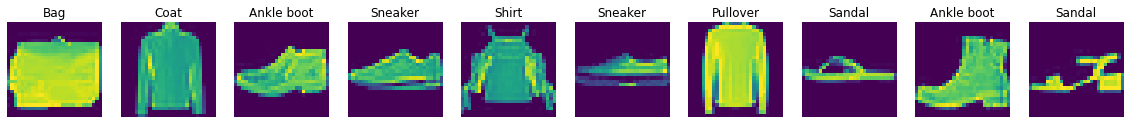

In [342]:
batch = ds.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=10, figsize=(20, 20))
for i in range(10):
    ax[i].set_title(class_names[batch[1][i]])
    ax[i].imshow(batch[0][i])
    ax[i].axis("off")

## 3. Build GAN

### 3.1 Import Model Components

In [343]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

### 3.2 Create Generator

In [344]:
build_generator = lambda : Sequential([
    # Random input values are reshaped to 7 x 7 x 128
    layers.Dense(7 * 7 * 128, input_dim=128),
    layers.LeakyReLU(0.2),
    layers.Reshape((7, 7, 128)),

    # Upsampling block (expands input)
    layers.UpSampling2D(),
    layers.Conv2D(128, 5, padding="same"),
    layers.LeakyReLU(0.2),

    # Upsampling block
    layers.UpSampling2D(),
    layers.Conv2D(128, 5, padding="same"),
    layers.LeakyReLU(0.2),

    # Convolutional Block
    layers.Conv2D(128, 4, padding="same"),
    layers.LeakyReLU(0.2),

    # Convolutional Block
    layers.Conv2D(128, 4, padding="same"),
    layers.LeakyReLU(0.2),

    layers.Conv2D(1, 4, padding="same", activation="sigmoid")
])

In [345]:
generator = build_generator()
generator.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_122 (LeakyReLU)  (None, 6272)             0         
                                                                 
 reshape_18 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_32 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_116 (Conv2D)         (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_123 (LeakyReLU)  (None, 14, 14, 128)      0         
                                                     

In [346]:
images = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 17ms/step


Images are returned with the shape of `(28, 28, 1)` so you need to reformat it to draw it with `plt`.
- `np.squeeze(image)`
- `image.reshape(28, 28)`

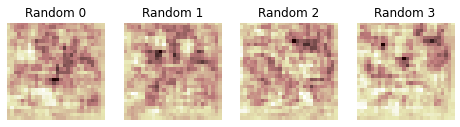

In [347]:
fig, ax = plt.subplots(ncols=4, figsize=(8, 8))

for i, image in enumerate(images):
    ax[i].set_title(f"Random {i}")
    ax[i].imshow(image.reshape(28, 28), cmap="pink")
    ax[i].axis("off")

### 3.3 Create Discriminator

In [348]:
build_discriminator = lambda : Sequential([
    # Convolutional block
    layers.Conv2D(32, 5, input_shape=(28, 28, 1)),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.4),

    # Convolutional block
    layers.Conv2D(64, 5),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.4),

    # Convolutional block
    layers.Conv2D(128, 5),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.4),

    # Convolutional block
    layers.Conv2D(256, 5),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid")
])

In [349]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_127 (LeakyReLU)  (None, 24, 24, 32)       0         
                                                                 
 dropout_48 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_122 (Conv2D)         (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_128 (LeakyReLU)  (None, 20, 20, 64)       0         
                                                                 
 dropout_49 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_123 (Conv2D)         (None, 16, 16, 128)     

In [350]:
discriminator.predict(images)

1/1 [==============================] - 0s 17ms/step


array([[0.5044124],
       [0.5044967],
       [0.5044657],
       [0.5044248]], dtype=float32)

## 4. Build Training Loop

### 4.1 Setup Losses and Optimizers

In [351]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [352]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Subclass Model

In [353]:
from tensorflow.keras.models import Model

In [354]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train discriminator
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_combined = tf.concat([yhat_real, yhat_fake], axis=0)

            # True y values
            # Real ones are 0 and fake ones are 1
            y_combined = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add noise to outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_combined += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss
            d_loss = self.d_loss(y_combined, yhat_combined)

        # Apply backpropagation
        d_grad = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))

        # Train generator
        with tf.GradientTape() as g_tape:
            # Generate images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss
            # Rewards generator for fooling discriminator
            g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation
        g_grad = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grad, self.generator.trainable_variables))

        return {
            "d_loss": d_loss,
            "g_loss": g_loss
        }

In [355]:
fashion_gan = FashionGAN(generator, discriminator)
fashion_gan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [356]:
import os 
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [357]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = (self.model.generator(random_latent_vectors) * 255).numpy()

        # Save generated images
        for i in range(self.num_img):
            image = array_to_img(generated_images[i])
            image.save(os.path.join(os.getcwd(), "exports", f"fashion_gan_{epoch}_{i}.png"))

### 4.4 Train Model

In [359]:
history = fashion_gan.fit(ds_scaled, epochs=200, callbacks=[ModelMonitor()])

Epoch 1/200
1094/1094 [==============================] - 152s 138ms/step - d_loss: 0.6381 - g_loss: 0.8823
Epoch 2/200
1094/1094 [==============================] - 153s 140ms/step - d_loss: 0.6457 - g_loss: 0.8718
Epoch 3/200
 671/1094 [=================>............] - ETA: 1:00 - d_loss: 0.6458 - g_loss: 0.8544

KeyboardInterrupt: 